In [1]:
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D, Activation
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import keras
import pickle
import os
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from imagenet_utils import *

Using TensorFlow backend.


In [2]:
num_class = 100
index_to_label = pickle.load(open('index_to_label.p','rb'))
keep = pickle.load(open('keep100.p', 'rb'))
label_to_index = {index_to_label[keep[i]]:i for i in range(len(keep))}
index_to_label = {u:v for v,u in label_to_index.items()}

In [3]:
model = create_net('inception_100_weights_finetuneAll_2epochs.h5', num_class)

In [4]:
train_path = 'train100/'
val_path = 'val100/'
test_path = 'test100/'
classes = sorted(os.listdir(val_path))

In [5]:
convLayers = []
for i in range(len(model.layers)):
    if ("mixed" in model.layers[i].name) & (model.layers[i].name[-2] != '_'):
        convLayers.append(model.layers[i])
convBlocks = getBlocks(convLayers)

obtain prediction on the test and their proba

In [6]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_gen = test_datagen.flow_from_directory(test_path,target_size=(299,299),class_mode='categorical',shuffle=False,batch_size=100)

Found 5000 images belonging to 100 classes.


In [7]:
test_gen.reset()
preds = model.predict_generator(test_gen, steps = test_gen.n // test_gen.batch_size, verbose = 1)

50/50 [==============================] - 271s 5s/step


In [9]:
pickle.dump(preds, open('test_pred100_viz.p', 'wb'))

In [6]:
preds = pickle.load(open('test_pred100_viz.p', 'rb'))

In [7]:
test_proba = np.max(preds, axis = 1)
test_preds = np.argmax(preds, axis = 1)
test_proba = test_proba.reshape((num_class,-1))
test_preds = test_preds.reshape((num_class,-1))

display cond of one correct and wrong predictions

In [8]:
#ind of all wrong predictions
wrong_ind = [np.arange(50)[test_preds[c] != c] for c in range(num_class)]

In [8]:
rights = pickle.load(open('rights100.p', 'rb'))
topFMs, topMeans, allClassMeans = oneG_extractTop(rights, num_class, convLayers, rank = 3)

In [47]:
#do it to compare the average top FM of all wrong pred and all correct pred
wrongs = pickle.load(open('wrongs100.p', 'rb'))
topFMs, topMeans, allClassMeans = oneG_extractTop(wrongs, num_class, convLayers, rank = 3)

In [ ]:
clear_distinction = []
for c in range(num_class):
    print(c)
    L = [(test_proba[c][w],w,test_preds[c][w]) for w in wrong_ind[c]]
    for couple in L:
        if couple[0] > 0.9:
            _, contribs_original = predCheck(model, -2, convLayers, couple[2], 0, test_path, topFMs, 
                                             index_to_label, test_preds, test_proba, figsize = (20,3),
                                             plot = False, rank = False)
            _, contribs = predCheck(model, -2, convLayers, c, couple[1], test_path, topFMs, 
                                    index_to_label, test_preds, test_proba, figsize = (20,3),
                                    plot = False, rank = False)
            contribs_original = np.sum(contribs_original)
            contribs = np.sum(contribs)
            if contribs*10 < contribs_original:
                clear_distinction.append((c,couple[1]))

predicted as 'matchstick' with proba 0.99101967
is actually 'orange'


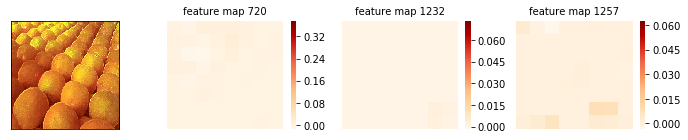

In [15]:
_, contribs_pred1 = predCheck(model, -3, convLayers, 92, 2, test_path, topFMs, 
                              index_to_label, test_preds, test_proba, allClassMeans,  
                              figsize = (12,2), plot = False, rank = False)

In [ ]:
_, contribs_pred2 = predCheck(model, -3, convLayers, label_to_index['matchstick'], 0, test_path, topFMs, 
                              index_to_label, test_preds, test_proba, allClassMeans,  
                              figsize = (12,2), plot = False, rank = False)

In [23]:
contribs = [(np.max(contrib), np.min(contrib)) for contrib in contribs_pred1]
contribs2 = [(np.max(contrib),np.min(contrib)) for contrib in contribs_pred2]
vi = [(max(contribs[i][0], contribs2[i][0]), min(contribs[i][1],contribs2[i][1])) for i in range(len(contribs))]

[(0.017778574, -0.015241548), (0.003008346, 0.0), (0.008376657, -0.0030609937)]

In [ ]:
contribs1, contribs_pred1 = predCheck(model, -3, convLayers, 92, 2, test_path, topFMs, 
                              index_to_label, test_preds, test_proba, allClassMeans, v = vi,  
                              figsize = (12,2), plot = True, rank = True)

predicted as 'matchstick' with proba 0.9999982
is actually 'matchstick'


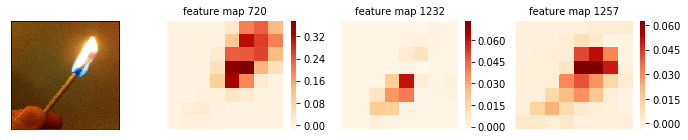

In [17]:
contribs2, contribs_pred2 = predCheck(model, -3, convLayers, label_to_index['matchstick'], 0, test_path, topFMs, 
                              index_to_label, test_preds, test_proba, allClassMeans, v = vi,  
                              figsize = (12,2), plot = True, rank = True)

BARPLOT ON A GROUP OF IMAGES

In [6]:
rights = pickle.load(open('rights100.p', 'rb'))
wrongs = pickle.load(open('wrongs100.p', 'rb'))

In [200]:
layer_num = len(convLayers) - 1
lastRLayer = [[rights[c][i][layer_num]*8*8 for i in range(len(rights[c]))] for c in range(num_class)]
lastWLayer = [[wrongs[c][i][layer_num]*8*8 for i in range(len(wrongs[c]))] for c in range(num_class)]

In [201]:
for c in range(num_class):
    lastRLayer[c] = np.array(lastRLayer[c])
    lastWLayer[c] = np.array(lastWLayer[c])
meanLastRLayer = [np.mean(classL, axis = 0) for classL in lastRLayer]
meanLastWLayer = [np.mean(classL, axis = 0) for classL in lastWLayer]

In [202]:
for c in range(num_class):
    lastRLayer[c] = np.array(lastRLayer[c])
    lastWLayer[c] = np.array(lastWLayer[c])
meanLastRLayer = [np.mean(classL, axis = 0) for classL in lastRLayer]
meanLastWLayer = [np.mean(classL, axis = 0) for classL in lastWLayer]
maxRMean = [np.max(m) for m in meanLastRLayer]
maxWMean = [np.max(m) for m in meanLastWLayer]
maxMean = [max(maxRMean[i], maxWMean[i]) for i in range(len(maxRMean))]
minRMean = [np.min(m) for m in meanLastRLayer]
minWMean = [np.min(m) for m in meanLastWLayer]
minMean = [min(minRMean[i], minWMean[i]) for i in range(len(minRMean))]

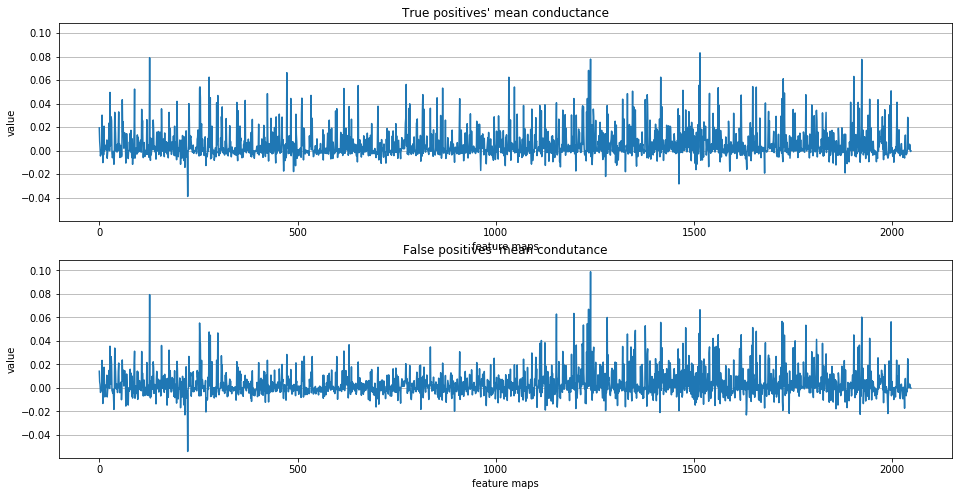

In [205]:
class_ind = 5
fig, axes = plt.subplots(2,1, figsize = (16,8))
axes[0].yaxis.grid(True)
axes[0].set_title('True positives\' mean conductance')
axes[0].set_ylabel('value')
axes[0].set_xlabel('feature maps')
axes[0].set_ylim(minMean[class_ind]+minMean[class_ind]/10, maxMean[class_ind]+maxMean[class_ind]/10)
axes[1].yaxis.grid(True)
axes[1].set_title('False positives\' mean condutance')
axes[1].set_ylabel('value')
axes[1].set_xlabel('feature maps')
axes[1].set_ylim(minMean[class_ind]+minMean[class_ind]/10, maxMean[class_ind]+maxMean[class_ind]/10)
sns.lineplot(x = np.arange(lastRLayer[c].shape[1]), y = meanLastRLayer[class_ind], ax = axes[0])
sns.lineplot(x = np.arange(lastWLayer[c].shape[1]), y = meanLastWLayer[class_ind], ax = axes[1])

BAR PLOT FOR ONE IMAGE

In [18]:
contribs = np.sum(contribs, axis = (0,1))
contribs2 = np.sum(contribs2, axis = (0,1))

In [19]:
max1 = np.max(contribs)
max2 = np.max(contribs2)
min1 = np.min(contribs)
min2 = np.min(contribs2)
maxi = max(max1,max2)
mini = min(min1,min2)

In [20]:
np.sum(contribs)

11.220783

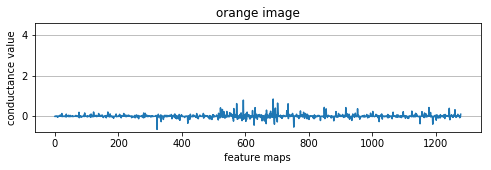

In [23]:
fig, axes = plt.subplots(1,1, figsize = (8,2))
axes.yaxis.grid(True)
axes.set_ylabel('conductance value')
axes.set_xlabel('feature maps')
axes.set_ylim(mini+mini/10, maxi + maxi/10)
axes.set_title('orange image')
sns.lineplot(np.arange(len(contribs)), contribs, ax = axes)
plt.savefig('orange_allcond.pdf', bbox_inches = 'tight')
# axes[1].yaxis.grid(True)
# axes[1].set_ylabel('conductance value')
# axes[1].set_xlabel('feature maps')
# axes[1].set_ylim(mini+mini/10, maxi + maxi/10)
# sns.lineplot(np.arange(len(contribs)), contribs2, ax = axes[1])

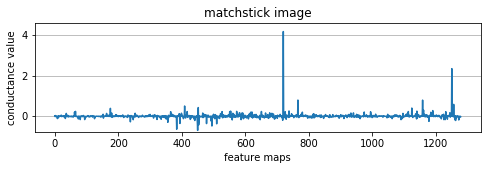

In [24]:
fig, axes = plt.subplots(1,1, figsize = (8,2))
axes.yaxis.grid(True)
axes.set_ylabel('conductance value')
axes.set_xlabel('feature maps')
axes.set_ylim(mini+mini/10, maxi + maxi/10)
axes.set_title('matchstick image')
sns.lineplot(np.arange(len(contribs)), contribs2, ax = axes)
plt.savefig('match_allcond.pdf', bbox_inches = 'tight')